In [1]:
using Flux
using JLD
using PyPlot

code_path = "../src"

push!(LOAD_PATH, code_path)
using AnomalyDetection
using ScikitLearn.Utils: meshgrid

In [2]:
# load data
dataset = load("toy_data_3.jld")["data"]
X = dataset.data
Y = dataset.labels
nX = X[:, Y.==0]

2×90 Array{Float64,2}:
 0.803442  0.804605  0.807145  0.819485  …  0.0350314  0.0613807  0.0685027
 0.821998  0.834235  0.826129  0.848182     0.973926   1.00745    0.973256 

In [3]:
# sVAE settings
indim = size(X,1)
hiddendim = 10
latentdim = 2
nlayers = 2
N = size(nX,2)

# setup the VAE object
ensize = [indim; hiddendim; hiddendim; latentdim*2] # encoder architecture
decsize = [latentdim; hiddendim; hiddendim; indim] # decoder architecture
dissize = [indim + latentdim; hiddendim; hiddendim; 1] # discriminator architecture
lambda = 10.0 # weight of the data error term
threshold = 0 # classification threshold, is recomputed during fit!()
contamination = size(Y[Y.==1],1)/size(Y, 1) # for automatic threshold computation
iterations = 10000
cbit = 5000 # after this number of iteratiosn, callback is printed
verbfit = true
L = 50 # batchsize
M = 1 #  number of samples of X in reconstruction error
activation = Flux.relu
rdelta = 1e-4 # reconstruction error threshold for training stopping
alpha = 0.5 # weighs between reconstruction error and discriminator score for classification
# 0 = only reconstruction error, 1 = only discriminator score
Beta = 1.0 # for automatic threshold computation, in [0, 1] 
# 1.0 = tight around normal samples
tracked = true # do you want to store training progress?
# it can be later retrieved from model.traindata
xsigma = 1.0 # static estimate of data variance
model = sVAEmodel(ensize, decsize, dissize, lambda, threshold, contamination, iterations, cbit, verbfit, 
    L, M = M, activation = activation, rdelta = rdelta, Beta = Beta, xsigma = xsigma,
    tracked = tracked)

AnomalyDetection.sVAEmodel(AnomalyDetection.sVAE(Chain(Chain(Dense(2, 10, NNlib.relu), Dense(10, 10, NNlib.relu)), Dense(10, 4)), AnomalyDetection.sample_z, Chain(Chain(Dense(2, 10, NNlib.relu), Dense(10, 10, NNlib.relu)), Dense(10, 2)), Chain(Chain(Dense(4, 10, NNlib.relu), Dense(10, 10, NNlib.relu)), Dense(10, 1)), Chain(Chain(Dense(4, 10, NNlib.relu), Dense(10, 10, NNlib.relu)), Dense(10, 1))), 10.0, 0, 0.1262135922330097, 10000, 5000, 50, 1, true, 0.0001, 0.5, 1.0, 1.0, Dict{Any,Any}())

In [4]:
# fit the model
AnomalyDetection.evalloss(model, nX)
AnomalyDetection.fit!(model, X, Y)
AnomalyDetection.evalloss(model, nX)

discriminator loss: 1.3210003895425086
VAE loss: 6.973997060015737
reconstruction error: 0.5003639379939145

discriminator loss: 1.3275165180107324
VAE loss: 0.48495913924446576
reconstruction error: 0.00812071642998019

discriminator loss: 1.4274722375689615
VAE loss: 0.4768614773669766
reconstruction error: 0.004358852369023807

discriminator loss: 1.3522435705210587
VAE loss: 0.2824272842094512
reconstruction error: 0.0071253081812015645



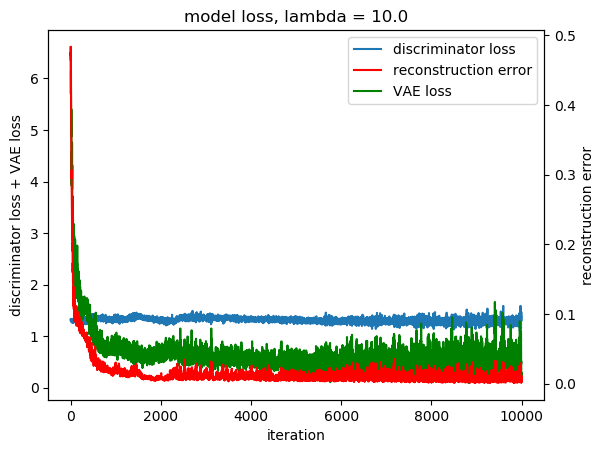

In [5]:
# plot model loss
plot(model)

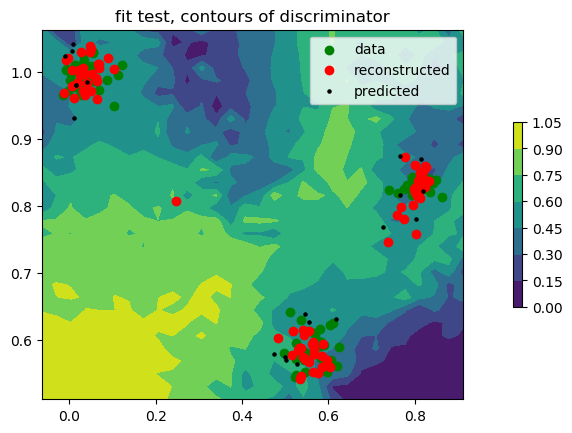

In [6]:
# plot heatmap of the fit
figure()
title("fit test, contours of discriminator")
scatter(nX[1, :], nX[2, :])
ax = gca()
xlim = ax[:get_xlim]()
ylim = ax[:get_ylim]()
xx, yy = meshgrid(linspace(xlim[1], xlim[2], 30), linspace(ylim[1], ylim[2], 30))
zz = zeros(size(xx))
for i in 1:size(xx, 1)
    for j in 1:size(xx, 2)
        _x = [xx[i,j], yy[i,j]]
        _z = Flux.Tracker.data(AnomalyDetection.getcode(model, _x))
        zz[i,j] = Flux.Tracker.data(AnomalyDetection.discriminate(model, _x, _z))[1]
    end
end
axsurf = ax[:contourf](xx, yy, zz)
cb = colorbar(axsurf, fraction = 0.05, shrink = 0.5, pad = 0.1)
scatter(nX[1, :], nX[2, :], c = "g", label = "data")
Xrec = Flux.Tracker.data(model(nX))
scatter(Xrec[1, :], Xrec[2, :], c = "r", label = "reconstructed")
Xpred = Flux.Tracker.data(AnomalyDetection.generate(model, 20))
scatter(Xpred[1, :], Xpred[2, :], c = "k", s=5, label = "predicted")
legend(loc = "upper right")
show()

In [7]:
model(nX)

Tracked 2×90 Array{Float64,2}:
 0.807757  0.804308  0.792763  0.80622   …  0.0486083  0.0283784  0.0585686
 0.830342  0.840454  0.818297  0.829916     0.97997    1.01662    0.985281 

In [8]:
nX

2×90 Array{Float64,2}:
 0.803442  0.804605  0.807145  0.819485  …  0.0350314  0.0613807  0.0685027
 0.821998  0.834235  0.826129  0.848182     0.973926   1.00745    0.973256 

In [9]:
AnomalyDetection.mu(model, nX)

Tracked 2×90 Array{Float64,2}:
 1.09168   1.12357   1.11027   1.19194   …  -1.01305   -0.727013  -0.927319
 0.876307  0.596336  0.863413  0.611433     -0.623899  -0.958901  -1.34483 

In [10]:
AnomalyDetection.sigma(model, nX)

Tracked 2×90 Array{Float64,2}:
 0.365711  0.368638  0.369968  0.385704  …  0.115208  0.0878568  0.0947058
 0.237605  0.26721   0.237875  0.260946     0.554359  0.669695   0.653856 

In [11]:
AnomalyDetection.sample_z(model, nX)

Tracked 2×90 Array{Float64,2}:
 1.2867   1.28678   0.557954  1.8019    …  -1.19504   -0.775852  -1.09835
 1.06624  0.488317  0.91695   0.304972     -0.351527  -2.01509   -2.09215

In [12]:
# predict labels
model.M = 20 # number of samples - for classification higher is better (more stable)
tryhat = AnomalyDetection.predict(model, X)

103-element Array{Int64,1}:
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 ⋮
 0
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1

In [13]:
# get the labels and roc stats
tryhat, tstyhat = AnomalyDetection.rocstats(dataset, dataset, model);


 Training data performance: 
MLBase.ROCNums{Int64}
  p = 13
  n = 90
  tp = 12
  tn = 90
  fp = 0
  fn = 1
precision: 1.0
recall: 0.9230769230769231
f1score: 0.96
equal error rate: 0.038461538461538464

 Testing data performance: 
MLBase.ROCNums{Int64}
  p = 13
  n = 90
  tp = 12
  tn = 90
  fp = 0
  fn = 1
precision: 1.0
recall: 0.9230769230769231
f1score: 0.96
equal error rate: 0.038461538461538464


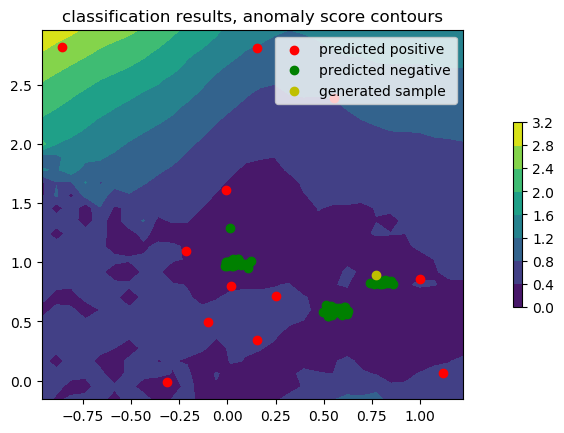

In [14]:
# plot heatmap of the fit
figure()
title("classification results, anomaly score contours")
scatter(X[1, :], X[2, :], c = "r")
ax = gca()
ylim = ax[:get_ylim]()
xlim = ax[:get_xlim]()
xx, yy = meshgrid(linspace(xlim[1], xlim[2], 30), linspace(ylim[1], ylim[2], 30))
zz = zeros(size(xx))
for i in 1:size(xx, 1)
    for j in 1:size(xx, 2)
        zz[i,j] = AnomalyDetection.anomalyscore(model, [xx[i,j], yy[i,j]]).tracker.data
    end
end
axsurf = ax[:contourf](xx, yy, zz)
cb = colorbar(axsurf, fraction = 0.05, shrink = 0.5, pad = 0.1)
scatter(X[1, tstyhat.==1], X[2, tstyhat.==1], c = "r", label = "predicted positive")
scatter(X[1, tstyhat.==0], X[2, tstyhat.==0], c = "g", label = "predicted negative")
b = AnomalyDetection.generate(model)
scatter(b[1], b[2], c = "y", label = "generated sample")
legend(loc = "upper right")
show()

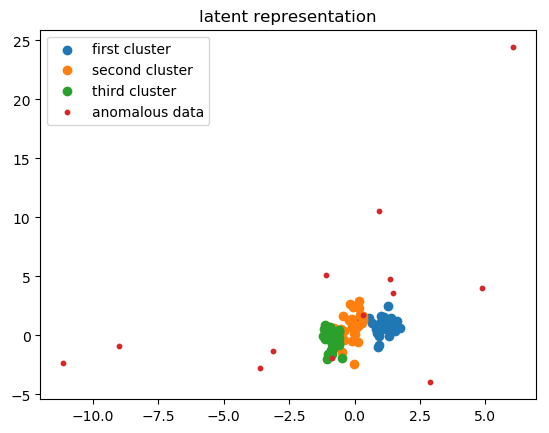

In [15]:
# what are the codes?
figure()
title("latent representation")
z1 = AnomalyDetection.getcode(model, X[:,1:30]).data
z2 = AnomalyDetection.getcode(model, X[:,31:60]).data
z3 = AnomalyDetection.getcode(model, X[:,61:90]).data
za = AnomalyDetection.getcode(model, X[:,91:end]).data

scatter(z1[1,:], z1[2,:], label = "first cluster")
scatter(z2[1,:], z2[2,:], label = "second cluster")
scatter(z3[1,:], z3[2,:], label = "third cluster")
scatter(za[1,:], za[2,:], s = 10, label = "anomalous data")
legend()
show()

In [18]:
using MLBase: false_positive_rate, false_negative_rate
n = 21
alphavec = linspace(0,1,n)
eervec = zeros(n)
for i in 1:n
    model.alpha = alphavec[i]
    AnomalyDetection.setthreshold!(model, X)
    tryhat, tsthat, trroc, tstroc = AnomalyDetection.rocstats(dataset.data, dataset.labels,
        dataset.data, dataset.labels, model, verb = false)
    eervec[i] = (false_positive_rate(tstroc) + false_negative_rate(tstroc))/2
end

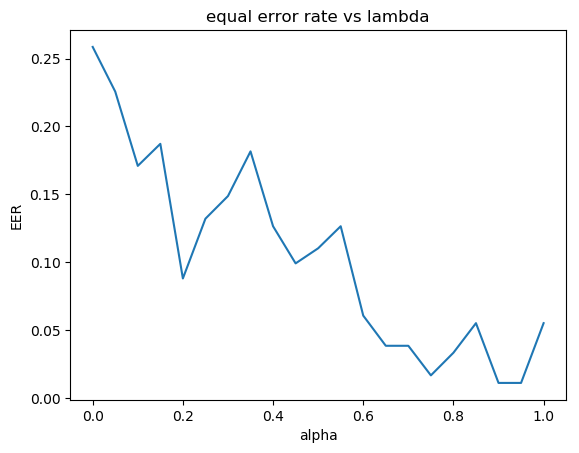

In [19]:
figure()
title("equal error rate vs lambda")
plot(alphavec, eervec)
xlabel("alpha")
ylabel("EER")
show()